In [1]:
import os
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline




Step 2: Prepare the Audio Data

In [2]:
def normalize_loudness(y):
    """Normalize audio to have consistent loudness."""
    rms = np.sqrt(np.mean(y**2))
    if rms > 0:
        y = y / rms
    return y

def load_and_preprocess_audio(file_path, target_sr=16000):
    """Load and preprocess audio file."""
    y, sr = librosa.load(file_path, sr=None)
    # Downsample if necessary
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    # Normalize loudness
    y = normalize_loudness(y)
    return y


2.2: Load Audio Files


In [3]:
# Path to your dataset folder
dataset_path = '../dataset'

# Get list of audio files
audio_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Preprocess and store audio data
audio_data = []

for file in tqdm(audio_files, desc='Loading and preprocessing audio files'):
    y = load_and_preprocess_audio(file)
    audio_data.append(y)



Loading and preprocessing audio files:   0%|          | 0/615 [00:00<?, ?it/s]

Step 3: Extract Features for RNN Input

3.1: Define Feature Extraction Function

In [4]:
def extract_mfcc_features(y, sr=16000, n_mfcc=40):
    """Extract MFCC features from audio signal."""
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = mfcc.T  # Shape: (Time steps, n_mfcc)
    return mfcc


3.2: Extract Features from All Audio Data

In [5]:
# List to hold feature sequences
feature_sequences = []

for y in tqdm(audio_data, desc='Extracting features'):
    features = extract_mfcc_features(y)
    feature_sequences.append(features)


Extracting features:   0%|          | 0/615 [00:00<?, ?it/s]

Step 4: Prepare Data for PyTorch

4.1: Create a Custom Dataset


In [6]:
class AudioDataset(Dataset):
    def __init__(self, feature_sequences):
        self.feature_sequences = feature_sequences

    def __len__(self):
        return len(self.feature_sequences)

    def __getitem__(self, idx):
        return self.feature_sequences[idx]


4.2: Define a Collate Function to Handle Variable Sequence Lengths

In [7]:
def collate_fn_fixed_length(batch):
    max_length = 100  # Define a fixed maximum sequence length
    batch_size = len(batch)
    n_features = batch[0].shape[1]

    # Create a tensor of zeros with shape (batch_size, max_length, n_features)
    padded_batch = torch.zeros(batch_size, max_length, n_features)

    for i, seq in enumerate(batch):
        length = min(seq.shape[0], max_length)
        padded_batch[i, :length, :] = torch.tensor(seq[:length])

    return padded_batch


4.3: Create DataLoader (New with Trainingset)

In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets (e.g., 80% training, 20% validation)
train_data, val_data = train_test_split(feature_sequences, test_size=0.2, random_state=42)

# Create DataLoaders for training and validation sets using the fixed-length collate function
train_dataset = AudioDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_fixed_length)

val_dataset = AudioDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_fixed_length)


Step 5: Define the RNN Autoencoder Model
5.1: Define the Model

In [11]:
class RNNAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNAutoencoder, self).__init__()
        self.hidden_size = hidden_size

        # Encoder
        self.encoder_rnn = nn.GRU(input_size, hidden_size, batch_first=True)

        # Decoder
        self.decoder_rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)

        # Output layer to map hidden_size back to input_size
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # Encoder
        _, hidden = self.encoder_rnn(x)

        # Decoder input: zeros
        batch_size, seq_len, _ = x.size()
        decoder_input = torch.zeros(batch_size, seq_len, self.hidden_size).to(x.device)

        # Decoder hidden state
        decoder_hidden = hidden

        # Decoder
        outputs, _ = self.decoder_rnn(decoder_input, decoder_hidden)

        # Map outputs to input_size
        outputs = self.output_layer(outputs)

        return outputs


5.2: Initialize the Model

In [14]:
input_size = feature_sequences[0].shape[1]  # n_mfcc
hidden_size = 128  # Adjust as needed

model = RNNAutoencoder(input_size, hidden_size)


Step 6: Define Loss Function and Optimizer

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



!!!!! OPTIONAL !!!! 


Resume Training form a previously saved model. (This means you need to run step 7 at least one time before)




In [13]:
# Load the model and optimizer if resuming training
model = RNNAutoencoder(input_size, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load the checkpoint (e.g., from the best model or specific epoch)
checkpoint = torch.load("checkpoints/best_autoencoder_model.pth")  # Or any specific checkpoint file

# Check if 'model_state_dict' exists in the checkpoint and load it into the model
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model state loaded successfully.")
else:
    raise ValueError("Checkpoint does not contain 'model_state_dict'.")

# Check if 'optimizer_state_dict' exists and load it into the optimizer
if 'optimizer_state_dict' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint.get('epoch', 0)  # Use 0 if epoch is not found
    print(f"Optimizer state and epoch {start_epoch} loaded successfully.")
else:
    print("Optimizer state not found in checkpoint. Starting from scratch.")
    start_epoch = 0  # Start from the beginning if no optimizer state is found

print(f"Resuming training from epoch {start_epoch}")


Model state loaded successfully.
Optimizer state and epoch 38 loaded successfully.
Resuming training from epoch 38


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_90448/553647371.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/best_auto

Step 7: Train the Model
New with tracking training progress

Epoch 1/5: 100%|██████████| 31/31 [00:01<00:00, 22.93it/s]


Epoch [1/5], Train Loss: 881.0333
Epoch [1/5], Val Loss: 841.9612
Full checkpoint saved for epoch 1
Removed old checkpoint: checkpoint_epoch_1.pth
Best model saved with validation loss: 841.9612


Epoch 2/5: 100%|██████████| 31/31 [00:01<00:00, 22.23it/s]


Epoch [2/5], Train Loss: 845.8605
Epoch [2/5], Val Loss: 821.1381
Full checkpoint saved for epoch 2
Removed old checkpoint: checkpoint_epoch_2.pth
Best model saved with validation loss: 821.1381


Epoch 3/5: 100%|██████████| 31/31 [00:01<00:00, 20.57it/s]


Epoch [3/5], Train Loss: 828.1832
Epoch [3/5], Val Loss: 800.7494
Full checkpoint saved for epoch 3
Removed old checkpoint: checkpoint_epoch_3.pth
Best model saved with validation loss: 800.7494


Epoch 4/5: 100%|██████████| 31/31 [00:01<00:00, 20.96it/s]


Epoch [4/5], Train Loss: 807.1512
Epoch [4/5], Val Loss: 781.2544
Full checkpoint saved for epoch 4
Removed old checkpoint: checkpoint_epoch_4.pth
Best model saved with validation loss: 781.2544


Epoch 5/5: 100%|██████████| 31/31 [00:01<00:00, 23.38it/s]


Epoch [5/5], Train Loss: 785.9940
Epoch [5/5], Val Loss: 763.4022
Full checkpoint saved for epoch 5
Best model saved with validation loss: 763.4022


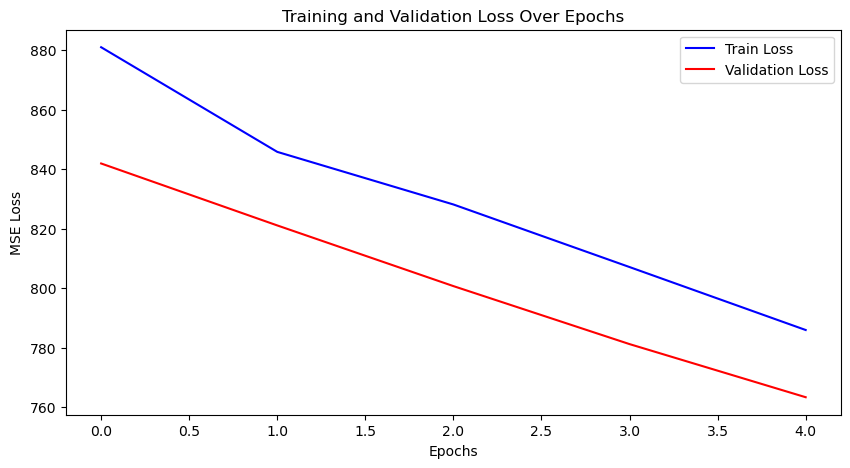

In [16]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check if a GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# **Define the Loss Function and Optimizer**
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store losses for both training and validation
train_losses = []
val_losses = []

# Set the number of epochs
num_epochs = 5  # Adjust this as necessary

# Best validation loss for saving the best model
best_val_loss = float('inf')

# Define where to save checkpoints and how many to keep
max_checkpoints = 5
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Begin training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0  # Initialize training loss for this epoch

    # Training loop
    for batch_data in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # Move data to the appropriate device (CPU or GPU)
        batch_data = batch_data.to(device).float()

        # Forward pass through the model
        outputs = model(batch_data)

        # Compute reconstruction loss (MSE between input and output)
        loss = criterion(outputs, batch_data)

        # Backward pass and optimization
        optimizer.zero_grad()  # Reset the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimizer step to update weights

        # Accumulate loss for this batch
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Print training loss for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    # Validate the model at the end of each epoch
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    val_loss = 0  # Initialize validation loss for this epoch

    # Validation loop (no gradient tracking)
    with torch.no_grad():  # Disables gradient calculations (saves memory)
        for val_data in val_dataloader:
            # Move validation data to the appropriate device
            val_data = val_data.to(device).float()

            # Forward pass on the validation data
            val_outputs = model(val_data)

            # Compute reconstruction loss on validation set
            loss = criterion(val_outputs, val_data)

            # Accumulate validation loss for this batch
            val_loss += loss.item()

    # Calculate average validation loss for this epoch
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Print validation loss for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}')

    # ---- Model Saving Strategies ---- #

    # 1. Save a full checkpoint after each epoch
    checkpoint = {
        'epoch': epoch + 1,  # Save the current epoch (0-indexed, so we add 1)
        'model_state_dict': model.state_dict(),  # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state
        'best_val_loss': best_val_loss,  # Keep track of best validation loss
    }
    torch.save(checkpoint, f"{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth")
    print(f"Full checkpoint saved for epoch {epoch+1}")

    # 2. Manage recent checkpoints (keep only the last `N` checkpoints and delete older ones)
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_epoch_")])
    if len(checkpoints) > max_checkpoints:
        os.remove(os.path.join(checkpoint_dir, checkpoints[0]))  # Remove the oldest checkpoint
        print(f"Removed old checkpoint: {checkpoints[0]}")

    # 3. Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(checkpoint, f"{checkpoint_dir}/best_autoencoder_model.pth")  # Save full checkpoint as best model
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Plot training and validation losses after all epochs are complete
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


Step 8: Analyze the Learned Representations
8.1: Extract Latent Features from the training data

In [17]:
latent_features = []

model.eval()  # Set to evaluation mode

# Extract latent features from training data only
with torch.no_grad():
    for batch_data in train_dataloader:
        batch_data = batch_data.to(device).float()

        # Encoder
        _, hidden = model.encoder_rnn(batch_data)

        latent_features.append(hidden.squeeze(0).cpu().numpy())

latent_features = np.vstack(latent_features)


8.2: Perform Clustering on Latent Features

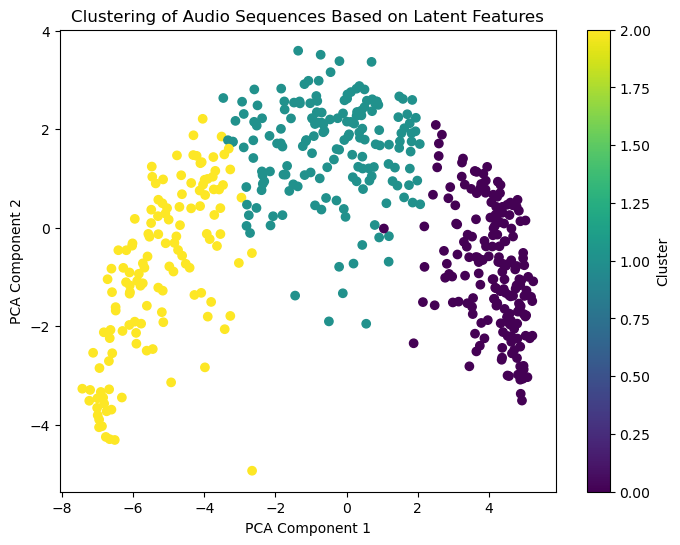

In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Perform clustering
n_clusters = 3  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(latent_features)

# Visualize using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(latent_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
plt.title('Clustering of Audio Sequences Based on Latent Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()


Step 9: Optional - Listen to Samples from Each Cluster

In [28]:
import IPython.display as ipd

def play_samples_from_clusters(labels, audio_data, n_clusters=3, max_samples_per_cluster=5):
    # Dictionary to track how many samples have been played from each cluster
    samples_played = {cluster: 0 for cluster in range(n_clusters)}
    
    # Iterate over the raw audio data and labels directly
    for index, y in enumerate(audio_data):
        # Get the cluster label for this sample
        cluster_label = labels[index]
        
        # Check if we've played the max number of samples for this cluster
        if samples_played[cluster_label] < max_samples_per_cluster:
            print(f'Playing audio from Cluster {cluster_label}')
            
            # Play the audio sample
            ipd.display(ipd.Audio(y, rate=16000))
            
            # Increment the count for this cluster
            samples_played[cluster_label] += 1
        
        # Stop if all clusters have played their max number of samples
        if all(samples_played[cluster] >= max_samples_per_cluster for cluster in samples_played):
            break

# Example Usage:
# Assuming 'labels' contains the cluster assignments (e.g., from KMeans)
# and 'audio_data' is the list of raw audio arrays corresponding to the dataset

play_samples_from_clusters(labels, audio_data, n_clusters=3, max_samples_per_cluster=5)


Playing audio from Cluster 1


Playing audio from Cluster 1


Playing audio from Cluster 2


Playing audio from Cluster 1


Playing audio from Cluster 0


Playing audio from Cluster 2


Playing audio from Cluster 2


Playing audio from Cluster 0


Playing audio from Cluster 2


Playing audio from Cluster 0


Playing audio from Cluster 0


Playing audio from Cluster 2


Playing audio from Cluster 0


Playing audio from Cluster 1


Playing audio from Cluster 1


10 Resume Model

In [22]:
import torch

# Define your RNNAutoencoder model
class RNNAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.encoder_rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=0.3)  # Dropout layer to prevent overfitting
        self.decoder_rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, x, lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, hidden = self.encoder_rnn(packed_input)
        hidden = self.dropout(hidden)  # Apply dropout
        batch_size, max_length, _ = x.size()
        decoder_input = torch.zeros(batch_size, max_length, self.hidden_size).to(x.device)
        outputs, _ = self.decoder_rnn(decoder_input, hidden)
        outputs = self.output_layer(outputs)
        return outputs

# Load the model and optimizer state if resuming training
input_size = 40  # Example input size (e.g., MFCC features)
hidden_size = 128  # Example hidden size

# Initialize the model and optimizer
model = RNNAutoencoder(input_size, hidden_size)

# Load from the last checkpoint if available
checkpoint_path = "checkpoints/best_autoencoder_model.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Model loaded from checkpoint at epoch {checkpoint['epoch']}.")


Model loaded from checkpoint at epoch 5.


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_98612/998827116.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

Cell 11: Export the Model to ONNX Format

In [23]:
import torch

# Define your RNNAutoencoder model (updated to remove 'lengths' and dynamic operations)
class RNNAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.encoder_rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=0.3)  # Dropout layer to prevent overfitting
        self.decoder_rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # Encoder
        _, hidden = self.encoder_rnn(x)
        hidden = self.dropout(hidden)  # Apply dropout

        # Decoder input: zeros
        batch_size, seq_len, _ = x.size()
        decoder_input = torch.zeros(batch_size, seq_len, self.hidden_size).to(x.device)

        # Decoder hidden state
        decoder_hidden = hidden

        # Decoder
        outputs, _ = self.decoder_rnn(decoder_input, decoder_hidden)

        # Map outputs to input_size
        outputs = self.output_layer(outputs)

        return outputs

# Load the model and optimizer state if resuming training
input_size = 40  # Example input size (e.g., MFCC features)
hidden_size = 128  # Example hidden size

# Initialize the model
model = RNNAutoencoder(input_size, hidden_size)

# Load from the last checkpoint if available
checkpoint_path = "checkpoints/best_autoencoder_model.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Model loaded from checkpoint at epoch {checkpoint['epoch']}.")


Model loaded from checkpoint at epoch 5.


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_98612/831921589.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

Step 1: Convert the ONNX Model to TensorFlow SavedModel

 Uninstall Standalone Keras   

In [34]:
!pip uninstall keras -y

Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0


Uninstall tensorflow and onnx

In [35]:
!pip uninstall tensorflow tensorflow-estimator onnx-tf -y

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: onnx-tf 1.10.0
Uninstalling onnx-tf-1.10.0:
  Successfully uninstalled onnx-tf-1.10.0


Install TensorFlow



In [37]:
pip install tensorflow

  Using cached tensorflow-2.17.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
Using cached tensorflow-2.17.0-cp310-cp310-macosx_12_0_arm64.whl (236.1 MB)
Using cached keras-3.5.0-py3-none-any.whl (1.1 MB)
Note: you may need to restart the kernel to use updated packages.


Install onnx 

In [39]:
!pip install onnx
!pip install git+https://github.com/onnx/onnx-tensorflow.git


  Cloning https://github.com/onnx/onnx-tensorflow.git to /private/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/pip-req-build-j34xwgy6
  Running command git clone --filter=blob:none --quiet https://github.com/onnx/onnx-tensorflow.git /private/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/pip-req-build-j34xwgy6
  Resolved https://github.com/onnx/onnx-tensorflow.git to commit ee0c5e537b3cebbddc5773871e6786e6468c7f3f
  Preparing metadata (setup.py) ... done
  Created wheel for onnx-tf: filename=onnx_tf-1.10.0-py3-none-any.whl size=226643 sha256=300ef81b60f30337a4b059b5addbb92dfd949c0d7aaa11305f55ee0d34e091e7
  Stored in directory: /private/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/pip-ephem-wheel-cache-m07uzhoh/wheels/26/8d/09/2c2cfa55123a5633aae58e44c4c6baf908c7f2e75470e0f392
Successfully built onnx-tf


Step 1: Install TensorFlow Probability

In [26]:
!pip install tensorflow-probability

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.6 MB/s eta 0:00:00a 0:00:01


In [27]:
import tensorflow_probability as tfp
print("TensorFlow Probability version:", tfp.__version__)

TensorFlow Probability version: 0.24.0


2. Check for Version

In [40]:
import tensorflow as tf
import onnx
import onnx_tf

print("TensorFlow version:", tf.__version__)
print("ONNX version:", onnx.__version__)
print("ONNX-TF version:", onnx_tf.__version__)


ModuleNotFoundError: No module named 'keras.src.engine'

1.2: Convert the ONNX Model to TensorFlow SavedModel

In [29]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX model
onnx_model = onnx.load("model.onnx")

# Convert the ONNX model to TensorFlow representation
tf_rep = prepare(onnx_model)

# Export the TensorFlow model as a SavedModel
tf_rep.export_graph("model_tf")


ModuleNotFoundError: No module named 'keras.src.engine'